# Training Models

In this notebook we explore how machine learning models actually work. Instead of viewing them as simply blackboxes, we will look at the algorythms behind how they are trained.

## Linear Regression

To begin with, we will look at the linear regression model. This model is trained by minimising the *mean squared error*. This can be done using a closed for solution to the *normal equation* or by an iterative method of *Gradient Descent*.

First, lets create some linear data:

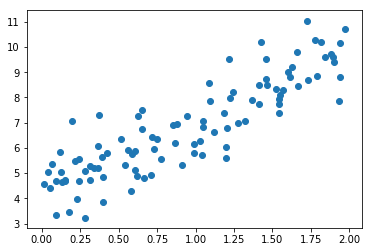

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

m = 100 # Number of instances
np.random.seed(42)
X = 2 * np.random.rand(m, 1)
y = 4 + 3 * X + np.random.randn(m, 1)
plt.scatter(X, y)
plt.show()

### Normal function (closed form solution)

Now lets compute the best set of parameters based on the solution to the normal function:

In [2]:
X_b = np.c_[np.ones((m, 1)), X] # adds x0=1 to each instance which allows for the intercept
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

The function actually used to create the data was y = 4X0 + 3X1 + noise. The outcome of the normal function is:

In [3]:
theta_best

array([[4.21509616],
       [2.77011339]])

[[4.21509616]
 [9.75532293]]


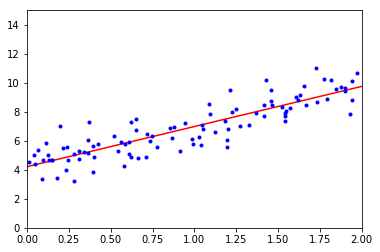

In [4]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
print(y_predict)

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [5]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

Comparing the coefficients from the normal function to the sklearn LinearRegression class, they are the same. The normal function method is good when there isn't a large number of features. The computational complexity relating to inverting a matrix is O(n^3), where n is the number of features. However, it is linear in the number of instances so is good for huge datasets. Also, it is linear in making predictions on data.

### Gradient Descent

The main idea is to make small changes to parameters to minimise a cost function. It is an optimisation problem.

At each step in the iteration, the algorythm computes the gradient using the full training set (called *batch gradient descent*). Because of this, it can be slow over large datasets. Fortunately, GD scales well with the number of features.

So the normal function works well for lots of instances with few features, while GD workds well for fewer instances but with lots of features.

Lets implement the GD algorithm. Fortunately in linear regression, the cost function (MSE) is convex and continuous, so providing you use enough iterations, the algorithm will always converge to the minimum.

In [6]:
eta = 0.1 # This is the learning rate (modifies the step size)
n_iterations = 1000

theta = np.random.randn(2, 1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    
theta

array([[4.21509616],
       [2.77011339]])

This gave the exact same results as the normal function method. Lets have a look at the difference the learning rate makes after 10 iterations:

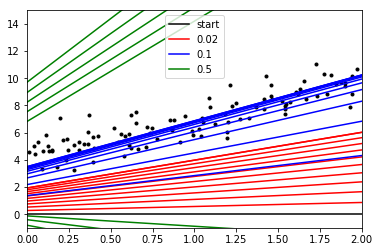

In [7]:
theta = [[0], [0]]

plt.plot(X, y, "k.")
plt.plot(X_new, X_new_b.dot(theta), "k-", label="start")
for eta, colour in zip([0.02, 0.1, 0.5], ['r-', 'b-', 'g-']):
    theta = [[0], [0]]
    for iteration in range(10):
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        plt.plot(X_new, X_new_b.dot(theta), colour)
    plt.plot(X_new, X_new_b.dot(theta), colour, label=str(eta))

plt.legend()    
plt.axis([0, 2, -1, 15])
plt.show()



So if the learning rate is too small (red), more iterations are needed. But if it is too large (green), the algorithm diverges.

#### Stochastic Gradient Descent

The problem with batch gradient descent is that it calculates the gradients using the entire training set which makes the computation slow. In stochastic GD, the gradient is calculated for just one instance taken at random, making the computation much faster. However, due to the randomness, the descent will be jumpy and only decrease on average. Also, once it gets to the bottom, it keps jumping around and will never settle. So the output values are good but not optimal.

This jumpiness can help get the algorithm out of a local mimimum by jumping out. So SGD is better at finding a global min than BGD.

To help with the randomness at the minimum, the learning rate can be reduced (*simulated annealing*) according to a *learning schedule*. The learning rate is reduced such that the jumps get smaller nearer the global minimum.

In [8]:
n_epochs = 50
t0, t1 = 5, 50 # learning shedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        
theta

array([[4.18475289],
       [2.73036719]])

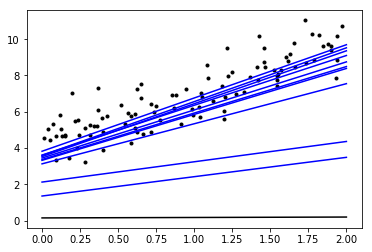

In [9]:
theta = np.random.randn(2, 1)

plt.plot(X, y, "k.")
plt.plot(X_new, X_new_b.dot(theta), "k-", label="start")

for i in range(10):
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(i)
    theta = theta - eta * gradients
    plt.plot(X_new, X_new_b.dot(theta), "b-")
    
plt.show()

Notice the irregular jumps in the first 10 iterations. Using the sklearn method (max_iter is the maximum number of epochs):

In [10]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1) # the penalty is the regularisation term
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([4.21599691]), array([2.77316023]))

#### Mini-batch gradient descent

Here, the gradients are computed on a small subset of the training set. This is a compromise between the two methods given above.

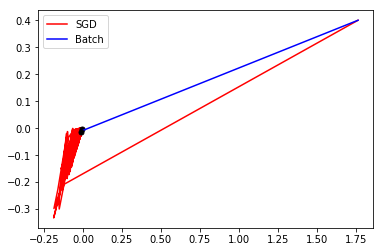

In [11]:
np.random.seed(0)
start = np.random.randn(2, 1)

# SGD
theta = start
for i in range(n_iterations):
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2 * xi.T.dot(xi.dot(theta[:, -1].reshape(2, 1)) - yi)
    eta = learning_schedule(i)*0.1
    theta = np.c_[theta, eta * gradients]

        
plt.plot(theta[0, :], theta[1, :], "r-", label="SGD")
plt.plot(theta[0, -1], theta[1, -1], "k.", markersize=10)


# Batch GD
theta = start
eta = 0.001
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta[:, -1].reshape(2, 1)) - y)
    theta = np.c_[theta, eta * gradients]

plt.plot(theta[0, :], theta[1, :], "b-", label="Batch")
plt.plot(theta[0, -1], theta[1, -1], "k.", markersize=10)

plt.legend()
plt.show()

After training, there is **no difference** between the different models. The difference is all in how they are trained. Each model makes predictions equally easily.

## Polynomial Regression

This can be done by adding powers of each feature to the training set as new features, and fit a linear model to this new training set.

Let's make some data:

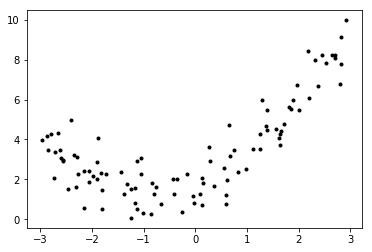

In [12]:
m = 100
np.random.seed(42)

X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, "k.")
plt.show()

Use sklearn PolynomialFeatures to add the square of each feature (there is only one feature in this case):

In [13]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0], X_poly[0])

[-0.75275929] [-0.75275929  0.56664654]


In [14]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

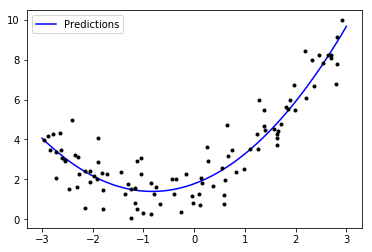

In [15]:
X_list = np.linspace(-3, 3, 100)
y_predict = lin_reg.intercept_ + lin_reg.coef_[0, 0] * X_list + lin_reg.coef_[0, 1] * X_list**2

plt.plot(X_list, y_predict, "b-", label="Predictions")
plt.plot(X, y, "k.")
plt.legend()
plt.show()

PolynomialFeatures can also be used to find relationships between features as it creates all possible combinations up to the specified degree.

To check the correct degree to fit the data to, use learning curves:

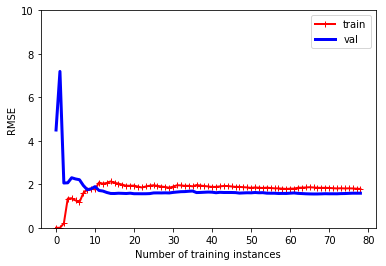

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
np.random.seed(42)

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.xlabel("Number of training instances")
    plt.ylabel("RMSE")
    plt.ylim(0, 10)
    plt.legend()
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

The trainnig error starts at zero since for only two points, the model can fit the data points perfectly. Both curves plateau since a straight line cannot perfectly fit the data. Thee curves are typical of an *underfitting* model (not enough degrees). In these cases, adding more trainnig data will not help improve the model. You either need a more complex model or mroe features.

Lets try now a tenth degree polynomial:

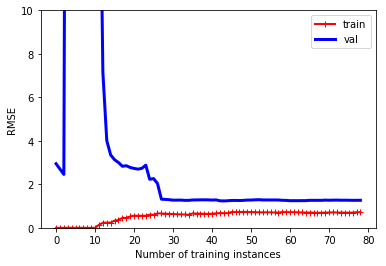

In [28]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)

In this case the model is *overfitting*. The gap between the curves indicates that the model performs much better on the training set than the validation set. Also note that the model fits the trainnig set perfectly up to 10 instances. To improve from overfitting, feed the model more trainnig instances until the val curve reaches the trainnig curve.

#### Bias/variance tradeoff

*Bias* is a generalisation error due to incorrect assumptions (bias on behalf of person) about the model. A high bias model is likely to be underfitting.

*Variance* is a generalisation error due to high sensitivity of the model to small variations in the training data. A high variance model is likely overfitting.

*Irreducible error* is due to noisy data. It can be reduced by cleaning the data.

### Regularised Linear Models

A term is added to the cost function to reduce the feature weights. The regularisation is only added during the training process. Evaluate the model using the unregularised performance measure.

It is important to scale the data before using regularisation as it is sensitive to the input features.

#### Ridge regression (Tikhonov regularisation)

Adds a regularisation term to the cost function proportional to the square of the l2 norm. This regulatisation term tries to minimise all the weights.

In [31]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver="cholesky") # This solver is closed-form solution method
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.82497007]])

In [33]:
# Using SGD:
sgd_reg = SGDRegressor(penalty="l2") # penalty of 0.5*l2^2 (l2 norm -> ridge) added to cost function
sgd_reg.fit(X, y)
sgd_reg.predict([[1.5]])

C:\Users\21493806\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\21493806\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([3.79202417])

#### Lasso Regression (*Least Absolute Shrinkage and Selection Operator Regression*)

Adds a regularisation term proportionl to the l1 norm. This regularisation tends to eliminate the weights of the unimportant features --> automatic feature selection.

In [34]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.77621741])

In [39]:
# Using SGD:
sgd_reg = SGDRegressor(penalty="l1")
sgd_reg.fit(X, y)
sgd_reg.predict([[1.5]])

C:\Users\21493806\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\21493806\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([3.81883512])

#### Elastic Net

This is a combination of Ridge and Lasso, characterised by a hyperparamter r. r=1 is lasso, r=0 is Ridge.

In [41]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5) # l1_ratio is the parameter r
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.78114505])

### Early stopping

A way of regularising iterative learning algorithms (such as SGD) is to stop training as soon as the validation reaches a minimum.

In [48]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

# prepare data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sdg_reg = SGDRegressor(n_iter=1, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005,
                      max_iter=5, tol=None)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train) # warm_start -> training continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
        
print(minimum_val_error, best_epoch)

C:\Users\21493806\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\21493806\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\21493806\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.l

24.702989987110726 163


## Logistic Regression

Uses a regression model to make classifications. The logistic (or simply *logit*) is a sigmoid function that outputs a number from 0 to 1 which represent probabilites of belonging to a class.

This regression uses a log-loss cost function that is convex. Gradient descent is guaranteed to find the minimum. However, there is no closed form solution.

Let us use the iris data set to illustrate logistic regression. The data set contains 3 different types of flower, we will try to predict if an instance belongs to only one type or not. There are 150 instances and 4 attributes.

We will use only one of the features (petal width):

In [50]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names']

In [55]:
X = iris["data"][:, 3:] # petal width
y = (iris["target"] == 2) # 1 if iris-virginica, 0 if else

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

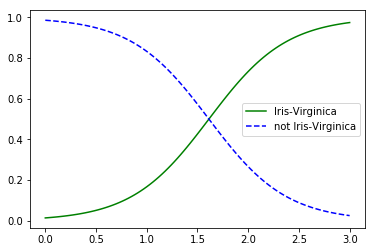

In [56]:
X_new = np.linspace(0, 3, 100).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="not Iris-Virginica")
plt.legend()
plt.show()

The corssing point in the above graph is the desicion boundary. Just like other regression models, logistic regression can also be regularised. Sklearn uses l2 regularisation by default.

### Softmax Regression (Multinomial Logistic Regression)

This is logistic regression which allows for multiple classes without having to train multiple binary classifiers. These models are trained by minimising the cross entropy cost function. Lets use it to classify all three flower types:

In [57]:
X = iris["data"][:, (2, 3)] # petal length and width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver = "lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [58]:
softmax_reg.predict([[5, 2]])

array([2])

In [59]:
softmax_reg.predict_proba([[5, 2]])

array([[6.33134077e-07, 5.75276067e-02, 9.42471760e-01]])

## Exercises

#### 1.
For a dataset with millions of features, a linear regression should be trained with a gradient descent algorithm. THe closed form method involves fuinding the inverse of a n dimensional matrix, where n is the number of features. This computation scales as the cube of n, so for millions of features, the closed form is very slow. In contrast, the gradient descent algorithm is linear in the number of features.

The choice of gradient descent to use depends on the number of instances. For large numbers of instances, a more stochastic algorithm would be more appropriate.

#### 2.
Scaling the features is not necessary for the closed form training method in linear regression. However, for gradient descent it is crucial that the features are all scaled the same. If the features are on different scales, the calculated gradient may be very large in one direction compared to others, which may increase the convergence time. In the stochastic case, this can also lead to larger jumps and a more eratic path.

#### 3.
The log loss cost function is convex, so any gradient descent algorithm will guarantee to find the global minimum provided the learning is not too large that the algorithm diverges. So GD will not get stuck locally in logistic regression.

#### 4. 
Provided the learning schedule allows for the learning rate to decrease, all GD algorithms will converge to the same point. Stochastic algorithms will jump around the minima but will be approximately the same as the batch algorithm.

However, if the cost function is quite complex such that there are local minima, the batch GD can get stuck in a local minimum. Stochastic algorithms have the chance of jumping out of these local minima and finding a better solution. In these cases, the different algorithms may not converge the same.

#### 5.
If the validation error is consistently increasing with each epoch, it is likely that the learning rate is too large and the algorithm is diverging. TO fix this, lower the learning rate.

#### 6.
Stopping the mini-batch algorithm when the validation error goes up is called *Early stopping*. It is a convenient way to prevent the model from overfitting when the model is exposed to the training data too many times.

#### 7.
Stochastic gradient descent is the fastest to reach the vicinity of the optimal solution, however without an appropriate learing schedule, the algorithm may jump around the solution and never reach a consistent solution. Batch GD will converge to a singlular solution, but is the slowest algorithm as it uses the entire dataset in each iteration. Mini-batch GD is a good combination between the two.

#### 8.
If there is a large gap between the validation and training errors in the learning curves of a polynomial regression, this indicates overfitting of the model. This can be fixed by:

1. Reducing the model complexity (ie, lowering the degree of the polynomial).
2. Find more instances to expand the training set.
3. Perform regularisation to the training.

#### 9. 
If both the training and validation error are equal and high, this indicates an underfitting of the model to the data. The model would suffer from high bias. In this case the ridge regularisation is hindering the model's ability to find some detail/complexity on the data. The alpha parameter should be decreased to remove some of the regularisation.

#### 10.
1. Ridge regression would be used to prevent some overfitting in the model.
2. Lasso regression would be used over ridge to only select the important features.
3. Elastic net combines the benefits of both lasso and ridge.

#### 11.
Since this task would be a multioutput binomial classifier, the softmax regression would not be appropriate. It would be better to use two logistic regression models.